![Banner](https://i.imgur.com/a3uAqnb.png)

# Building and Optimizing a CNN - Homework Assignment

In this homework, you will design, implement, and optimize a **Convolutional Neural Network (CNN)** using PyTorch to classify images from the CIFAR-10 dataset. This will involve advanced preprocessing techniques, sophisticated model architectures, hyperparameter tuning, and comprehensive evaluation.

## 📌 Project Overview
- **Task**: Image classification on CIFAR-10 dataset
- **Architecture**: CNN with Inception bottlenecks and advanced optimizations
- **Dataset**: CIFAR-10 (60,000 32x32 color images in 10 classes)
- **Goal**: Achieve high classification accuracy with optimized training

## 📚 Learning Objectives
By completing this assignment, you will:
- Implement advanced data augmentation techniques
- Design complex CNN architectures with Inception bottlenecks
- Compare different optimizers and learning rate schedules
- Apply various regularization techniques
- Evaluate models with comprehensive metrics
- Visualize training progress and results

## 1️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, and related libraries
- Import matplotlib, numpy, and other utilities
- Set random seeds for reproducibility
- Configure hyperparameters with reasonable values

In [44]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader
import time
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device availability and print
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

# Define configuration parameters
BATCH_SIZE = 2**9  # Batch size for training
LEARNING_RATE = 0.001  # Initial learning rate
NUM_EPOCHS = 5  # Number of training epochs
NUM_CLASSES = 10  # CIFAR-10 has 10 classes
INPUT_SIZE = 32  # CIFAR-10 image size is 32x32

print(f"\nConfiguration:")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Input Size: {INPUT_SIZE}x{INPUT_SIZE}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti SUPER
Memory: 15 GB

Configuration:
Batch Size: 512
Learning Rate: 0.001
Number of Epochs: 5
Number of Classes: 10
Input Size: 32x32


## 2️⃣ Load and Preprocess the Data

**Task**: Load CIFAR-10 dataset and implement advanced preprocessing techniques.

**Requirements**:
- Load CIFAR-10 training and test sets
- Apply data normalization using dataset statistics
- Implement comprehensive data augmentation for training
- Create data loaders with appropriate settings

Dataset Information:
Training samples: 50000
Test samples: 10000
Number of classes: 10
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Training batches: 98
Test batches: 20

Sample images from training set:


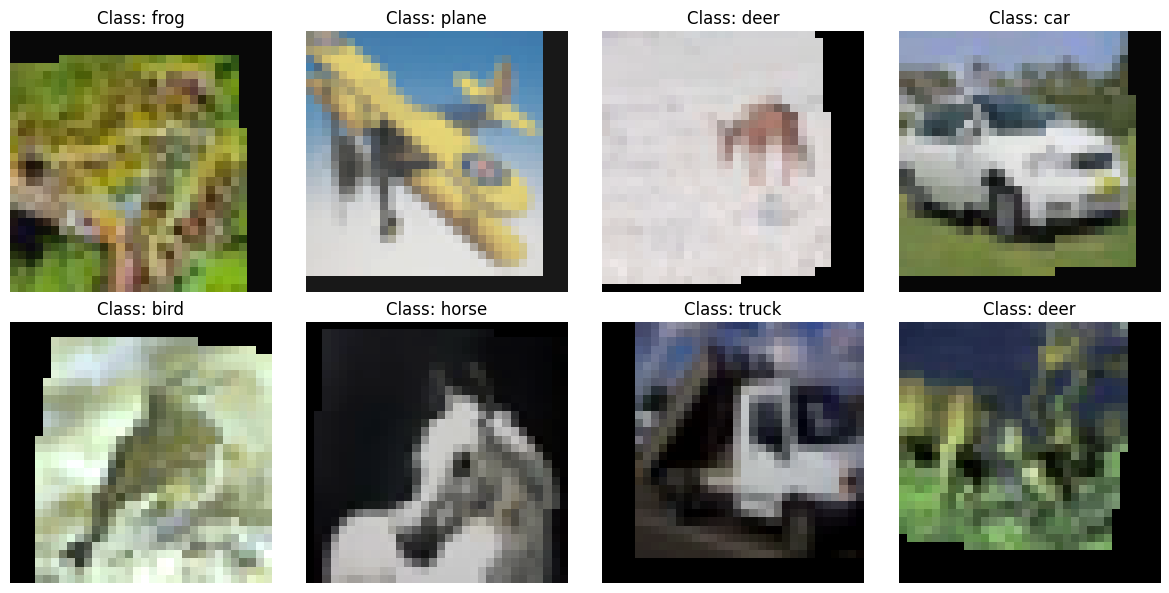

In [45]:
# Define data transforms for training (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define data transforms for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Print dataset information
print("Dataset Information:")
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Training batches: {len(trainloader)}")
print(f"Test batches: {len(testloader)}")

# Visualize some sample images with their labels
def visualize_samples(dataloader, num_samples=8):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img = images[i]
        # Denormalize
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img_np = img.numpy().transpose((1, 2, 0))
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'Class: {classes[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nSample images from training set:")
visualize_samples(trainloader)

## 3️⃣ Design Complex CNN Architecture with Inception Bottlenecks

**Task**: Implement a sophisticated CNN architecture incorporating Inception-style bottleneck blocks.

**Requirements**:
- Create an Inception bottleneck module with multiple parallel paths
- Design the main CNN with multiple Inception blocks
- Use appropriate pooling, batch normalization, and dropout
- Implement skip connections where beneficial

In [46]:
# Create InceptionBottleneck class
class InceptionBottleneck(nn.Module):
    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_pool):
        super(InceptionBottleneck, self).__init__()
        
        # Path 1: 1x1 convolution
        self.path1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(inplace=True)
        )
        
        # Path 2: 1x1 reduction + 3x3 convolution
        self.path2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.BatchNorm2d(reduce_3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(inplace=True)
        )
        
        # Path 3: 1x1 reduction + 5x5 convolution
        self.path3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.BatchNorm2d(reduce_5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(inplace=True)
        )
        
        # Path 4: 3x3 max pooling + 1x1 projection
        self.path4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Pass input through all four paths
        out1 = self.path1(x)
        out2 = self.path2(x)
        out3 = self.path3(x)
        out4 = self.path4(x)
        
        # Concatenate outputs along channel dimension
        output = torch.cat([out1, out2, out3, out4], dim=1)
        return output

# Create main CNN class
class InceptionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionCNN, self).__init__()
        
        # Initial layers
        self.initial_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1)
        )
        
        # First set of Inception blocks
        self.inception1 = InceptionBottleneck(64, 16, 32, 64, 16, 32, 32)  # Output: 144 channels
        self.inception2 = InceptionBottleneck(144, 32, 64, 128, 32, 64, 64)  # Output: 288 channels
        
        self.pool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )
        
        # Second set of Inception blocks
        self.inception3 = InceptionBottleneck(288, 64, 128, 256, 64, 128, 128)  # Output: 576 channels
        self.inception4 = InceptionBottleneck(576, 128, 256, 512, 128, 256, 256)  # Output: 1152 channels
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1152, num_classes)
        )
    
    def forward(self, x):
        # Pass through initial layers
        x = self.initial_layers(x)
        
        # Pass through first inception blocks
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool1(x)
        
        # Pass through second inception blocks
        x = self.inception3(x)
        x = self.inception4(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        
        # Flatten before classifier
        x = x.view(x.size(0), -1)
        
        # Pass through classifier
        x = self.classifier(x)
        
        return x

# Initialize model and move to device
model = InceptionCNN(num_classes=NUM_CLASSES).to(device)

# Print model architecture and parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal trainable parameters: {count_parameters(model):,}")

# Test with random input to verify output shape
test_input = torch.randn(1, 3, 32, 32).to(device)
test_output = model(test_input)
print(f"\nTest input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"Expected output shape: [1, {NUM_CLASSES}]")

Model Architecture:
InceptionCNN(
  (initial_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (inception1): InceptionBottleneck(
    (path1): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (path2): Sequential(
      (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## 4️⃣ Implement and Compare Different Optimizers

**Task**: Set up multiple optimizers and compare their performance.

**Requirements**:
- Implement SGD, Adam, and AdamW optimizers
- Use appropriate hyperparameters for each
- Create a function to easily switch between optimizers

In [47]:
# Create function to get optimizer
def get_optimizer(model, optimizer_name, learning_rate):
    """
    Create and return the specified optimizer with appropriate hyperparameters.
    
    Args:
        model: The neural network model
        optimizer_name: String name of optimizer ('sgd', 'adam', 'adamw')
        learning_rate: Learning rate for the optimizer
    
    Returns:
        optimizer: Configured optimizer
    """
    if optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(
            model.parameters(), 
            lr=learning_rate, 
            momentum=0.9, 
            weight_decay=1e-4
        )
    elif optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            betas=(0.9, 0.999), 
            weight_decay=1e-4
        )
    elif optimizer_name.lower() == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(), 
            lr=learning_rate, 
            betas=(0.9, 0.999), 
            weight_decay=1e-2
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}. Choose from 'sgd', 'adam', 'adamw'")
    
    return optimizer

# Initialize optimizer (using AdamW as recommended)
optimizer_name = 'adamw'
optimizer = get_optimizer(model, optimizer_name, LEARNING_RATE)

# Print optimizer configuration
print(f"Selected Optimizer: {optimizer_name.upper()}")
print(f"Optimizer configuration:")
print(optimizer)

Selected Optimizer: ADAMW
Optimizer configuration:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


## 5️⃣ Use Learning Rate Scheduling

**Task**: Implement learning rate scheduling for improved training dynamics.

**Requirements**:
- Use StepLR or CosineAnnealingLR scheduler
- Configure appropriate scheduling parameters
- Track learning rate changes during training

In [48]:
# Create learning rate scheduler
# Using CosineAnnealingLR for smooth learning rate decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Alternative option: StepLR (uncomment to use instead)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

print(f"Learning Rate Scheduler: CosineAnnealingLR")
print(f"T_max: {NUM_EPOCHS}")
print(f"eta_min: 1e-6")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")

# Create function to get current learning rate from optimizer
def get_current_lr(optimizer):
    """Get the current learning rate from the optimizer."""
    return optimizer.param_groups[0]['lr']

# Initialize list to track learning rates during training
learning_rates = []

print(f"\nCurrent learning rate: {get_current_lr(optimizer)}")

Learning Rate Scheduler: CosineAnnealingLR
T_max: 5
eta_min: 1e-6
Initial learning rate: 0.001

Current learning rate: 0.001


## 6️⃣ Apply Regularization Techniques  

**Task**: Implement various regularization methods to prevent overfitting.

**Requirements**:
- Use dropout in your model (already included in architecture)
- Implement early stopping mechanism
- Add L2 weight decay (already in optimizer)
- Optional: implement label smoothing

In [49]:
# Create EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Early stopping to stop training when validation loss stops improving.
        
        Args:
            patience: Number of epochs to wait after last improvement
            min_delta: Minimum change to qualify as an improvement
            restore_best_weights: Whether to restore best weights when stopping
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        """
        Check if training should stop and save best model weights.
        
        Args:
            val_loss: Current validation loss
            model: The model to potentially save weights from
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        """Save the current model weights."""
        self.best_weights = copy.deepcopy(model.state_dict())

# Initialize early stopping with patience=10
early_stopping = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

print("Regularization Techniques Applied:")
print("1. Dropout layers in model architecture:")
print("   - Dropout2d(0.1) after initial layers")
print("   - Dropout2d(0.2) after first pooling")
print("   - Dropout(0.5) before final classifier")
print("\n2. Batch Normalization in all convolutional layers")
print("\n3. L2 Weight Decay in optimizer:")
print(f"   - Weight decay: {optimizer.param_groups[0]['weight_decay']}")
print("\n4. Early Stopping:")
print(f"   - Patience: {early_stopping.patience} epochs")
print(f"   - Min delta: {early_stopping.min_delta}")
print(f"   - Restore best weights: {early_stopping.restore_best_weights}")

# Optional: Create label smoothing loss function
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        """
        Label smoothing cross entropy loss.
        
        Args:
            smoothing: Smoothing parameter (0.0 = no smoothing)
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        """
        Forward pass of label smoothing loss.
        
        Args:
            pred: Predictions from model
            target: True labels
            
        Returns:
            loss: Smoothed cross entropy loss
        """
        n_classes = pred.size(-1)
        log_preds = torch.log_softmax(pred, dim=-1)
        
        # Create smoothed targets
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
            
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))

# Initialize label smoothing loss (optional)
label_smoothing_loss = LabelSmoothingCrossEntropy(smoothing=0.1)

print("\n5. Optional Label Smoothing:")
print(f"   - Smoothing parameter: {label_smoothing_loss.smoothing}")
print("   - Mixes true labels with uniform distribution")

print(f"\nEarly stopping initialized and ready for training.")

Regularization Techniques Applied:
1. Dropout layers in model architecture:
   - Dropout2d(0.1) after initial layers
   - Dropout2d(0.2) after first pooling
   - Dropout(0.5) before final classifier

2. Batch Normalization in all convolutional layers

3. L2 Weight Decay in optimizer:
   - Weight decay: 0.01

4. Early Stopping:
   - Patience: 10 epochs
   - Min delta: 0.001
   - Restore best weights: True

5. Optional Label Smoothing:
   - Smoothing parameter: 0.1
   - Mixes true labels with uniform distribution

Early stopping initialized and ready for training.


## 7️⃣ Training Loop with Advanced Features

**Task**: Implement comprehensive training loop with all optimizations.

**Requirements**:
- Track multiple metrics during training
- Implement proper validation
- Save best model checkpoints
- Monitor learning rate and loss curves

In [50]:
# Define loss function (using standard CrossEntropyLoss)
# criterion = nn.CrossEntropyLoss()
# Alternative: Use label smoothing loss
criterion = label_smoothing_loss

# Initialize tracking lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

# Training loop
print("Starting training...")
print("="*80)

start_time = time.time()
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track running loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
    
    # Calculate training metrics
    train_loss = running_train_loss / len(trainloader)
    train_acc = 100.0 * correct_train / total_train
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, target in testloader:
            # Move data to device
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Track running loss and accuracy
            running_val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    
    # Calculate validation metrics
    val_loss = running_val_loss / len(testloader)
    val_acc = 100.0 * correct_val / total_val
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    learning_rates.append(get_current_lr(optimizer))
    
    # Step learning rate scheduler
    scheduler.step()
    
    # Check early stopping
    if early_stopping(val_loss, model):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break
    
    # Save best model if validation improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch statistics
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} completed in {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {get_current_lr(optimizer):.6f}')
    print(f'Best Val Acc so far: {best_val_acc:.2f}%')
    print('-' * 80)


Starting training...
Epoch 1/5 completed in 9.32s
Train Loss: 1.8466, Train Acc: 37.05%
Val Loss: 1.5336, Val Acc: 52.69%
Learning Rate: 0.000905
Best Val Acc so far: 52.69%
--------------------------------------------------------------------------------
Epoch 2/5 completed in 9.11s
Train Loss: 1.5140, Train Acc: 54.76%
Val Loss: 1.4156, Val Acc: 60.69%
Learning Rate: 0.000655
Best Val Acc so far: 60.69%
--------------------------------------------------------------------------------
Epoch 3/5 completed in 9.25s
Train Loss: 1.3688, Train Acc: 62.25%
Val Loss: 1.2766, Val Acc: 67.22%
Learning Rate: 0.000346
Best Val Acc so far: 67.22%
--------------------------------------------------------------------------------
Epoch 4/5 completed in 9.09s
Train Loss: 1.2839, Train Acc: 66.90%
Val Loss: 1.2222, Val Acc: 71.16%
Learning Rate: 0.000096
Best Val Acc so far: 71.16%
--------------------------------------------------------------------------------
Epoch 5/5 completed in 9.06s
Train Loss: 1.


Training completed!
Total training time: 0.87 minutes
Best validation accuracy: 74.37%


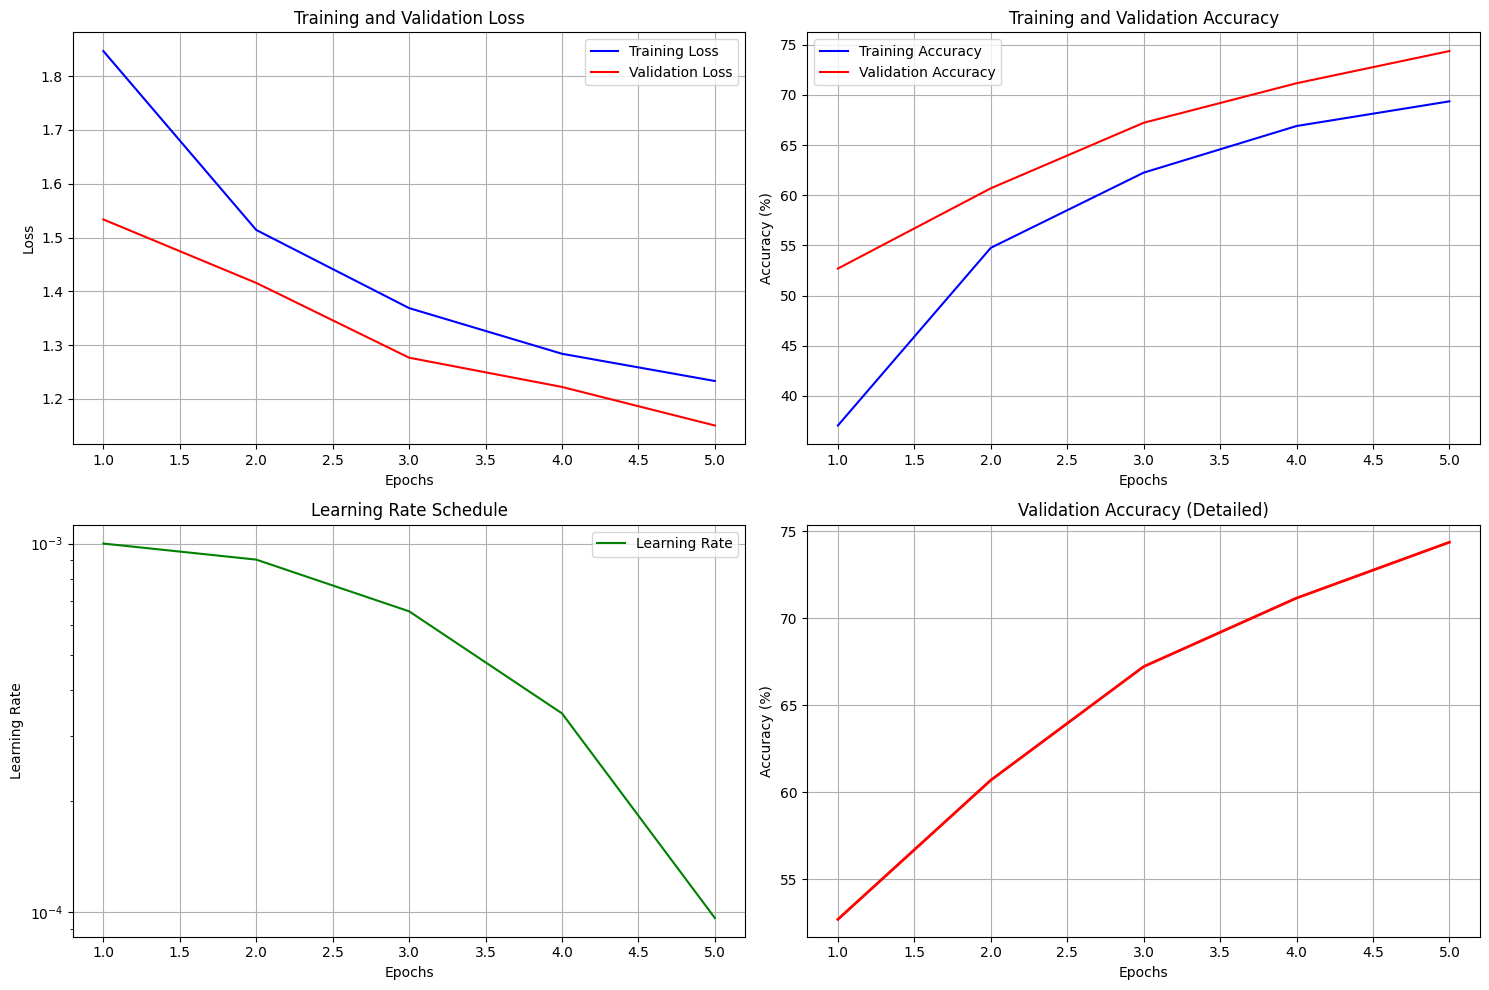

In [51]:
# Calculate total training time
total_time = time.time() - start_time
print(f"\nTraining completed!")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot loss curves
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy curves
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Plot learning rate schedule
ax3.plot(epochs_range, learning_rates, 'g-', label='Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Learning Rate')
ax3.legend()
ax3.grid(True)
ax3.set_yscale('log')

# Plot validation accuracy zoomed
ax4.plot(epochs_range, val_accuracies, 'r-', linewidth=2)
ax4.set_title('Validation Accuracy (Detailed)')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy (%)')
ax4.grid(True)
ax4.set_ylim([min(val_accuracies) - 1, max(val_accuracies) + 1])

plt.tight_layout()
plt.show()

## 8️⃣ Evaluate Model with Advanced Metrics

**Task**: Comprehensive evaluation using multiple metrics and visualizations.

**Requirements**:
- Calculate accuracy, precision, recall, F1-score
- Generate confusion matrix
- Analyze per-class performance
- Visualize misclassified examples

Loaded best model weights
Evaluating model on test set...

OVERALL PERFORMANCE METRICS
Overall Accuracy: 0.7437 (74.37%)
Macro Average - Precision: 0.7413, Recall: 0.7437, F1: 0.7404
Weighted Average - Precision: 0.7413, Recall: 0.7437, F1: 0.7404

PER-CLASS PERFORMANCE METRICS
Class      Accuracy   Precision  Recall     F1-Score   Support   
--------------------------------------------------------------------------------
plane      0.8040     0.7263     0.8040     0.7632     1000      
car        0.9060     0.8523     0.9060     0.8783     1000      
bird       0.6100     0.6956     0.6100     0.6500     1000      
cat        0.4680     0.6054     0.4680     0.5279     1000      
deer       0.7160     0.6878     0.7160     0.7016     1000      
dog        0.6750     0.6153     0.6750     0.6438     1000      
frog       0.7600     0.7908     0.7600     0.7751     1000      
horse      0.7630     0.7965     0.7630     0.7794     1000      
ship       0.8400     0.8687     0.8400     0.

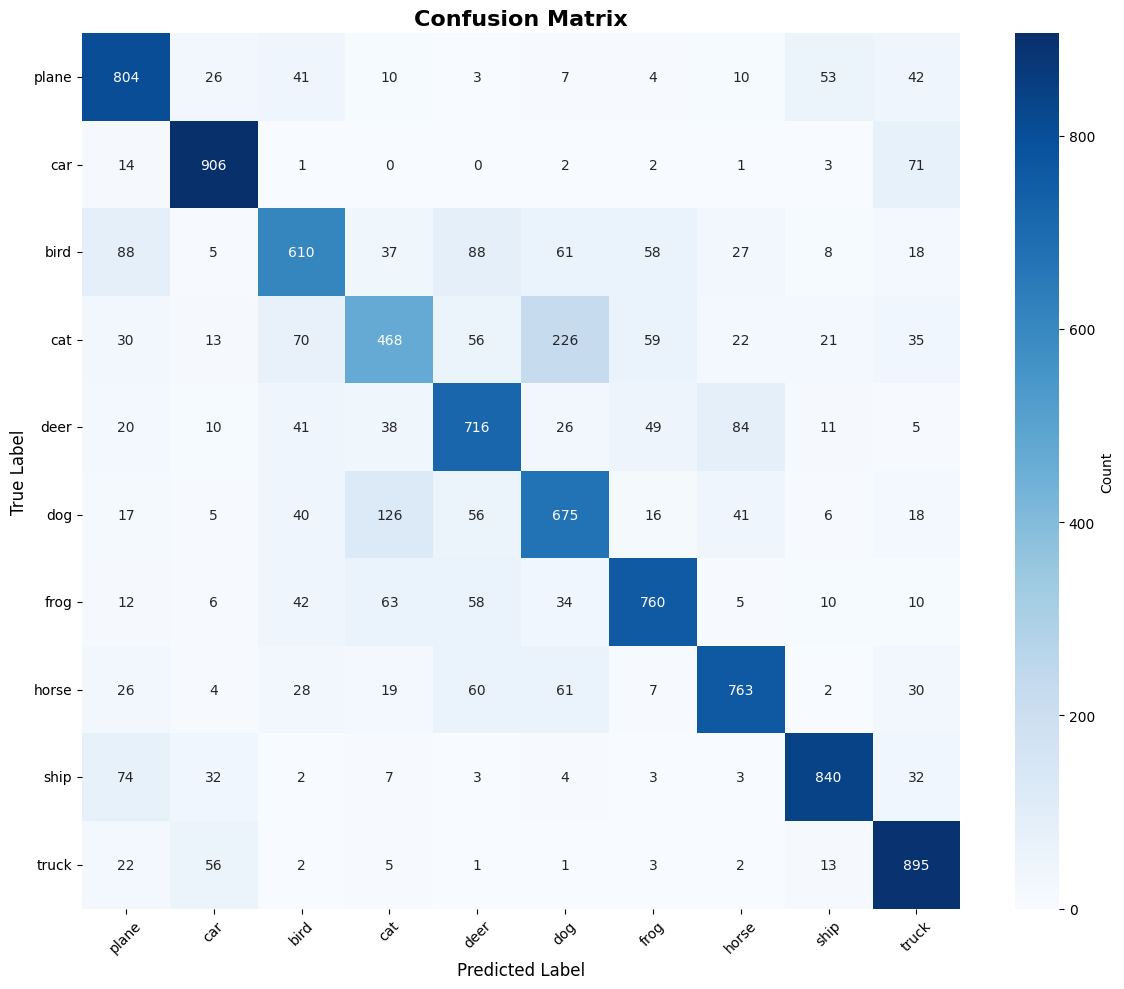

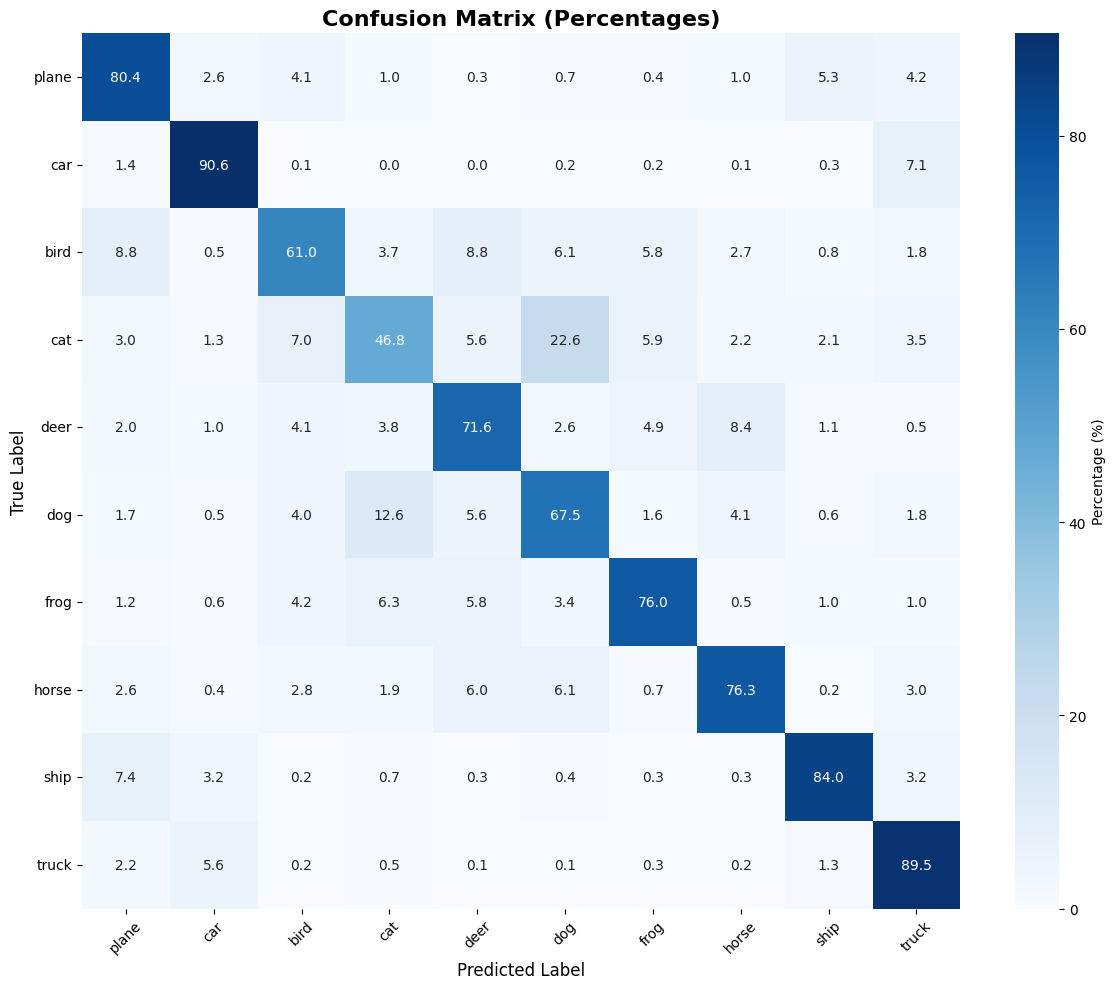


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       plane     0.7263    0.8040    0.7632      1000
         car     0.8523    0.9060    0.8783      1000
        bird     0.6956    0.6100    0.6500      1000
         cat     0.6054    0.4680    0.5279      1000
        deer     0.6878    0.7160    0.7016      1000
         dog     0.6153    0.6750    0.6438      1000
        frog     0.7908    0.7600    0.7751      1000
       horse     0.7965    0.7630    0.7794      1000
        ship     0.8687    0.8400    0.8541      1000
       truck     0.7742    0.8950    0.8302      1000

    accuracy                         0.7437     10000
   macro avg     0.7413    0.7437    0.7404     10000
weighted avg     0.7413    0.7437    0.7404     10000


Finding misclassified examples...


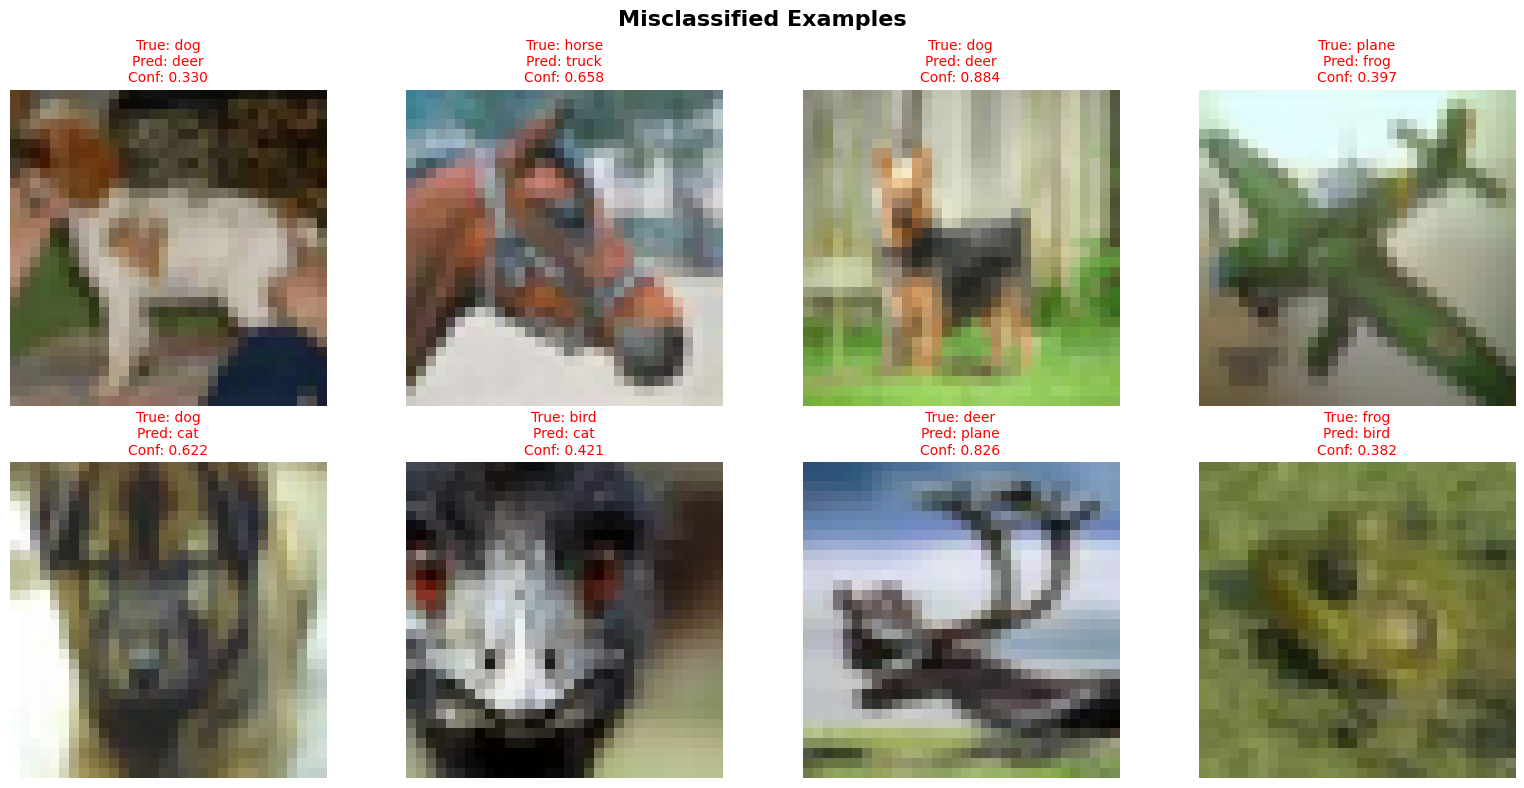


Evaluation completed!
Found 8 misclassified examples for visualization.


In [52]:
# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded best model weights")

# Create evaluation function
def evaluate_model(model, dataloader, device, classes):
    """
    Comprehensive evaluation of the model.
    
    Returns:
        accuracy, predictions, true_labels, class_accuracies
    """
    model.eval()
    all_predictions = []
    all_labels = []
    correct_by_class = [0] * len(classes)
    total_by_class = [0] * len(classes)
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            
            # Calculate per-class accuracy
            for i in range(len(target)):
                label = target[i].item()
                total_by_class[label] += 1
                if predicted[i] == target[i]:
                    correct_by_class[label] += 1
    
    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # Calculate per-class accuracies
    class_accuracies = []
    for i in range(len(classes)):
        if total_by_class[i] > 0:
            class_acc = correct_by_class[i] / total_by_class[i]
        else:
            class_acc = 0
        class_accuracies.append(class_acc)
    
    return accuracy, all_predictions, all_labels, class_accuracies

# Generate predictions on test set
print("Evaluating model on test set...")
accuracy, predictions, true_labels, class_accuracies = evaluate_model(model, testloader, device, classes)

# Calculate precision, recall, F1-score
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, average=None, labels=range(len(classes))
)

# Calculate macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    true_labels, predictions, average='macro'
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    true_labels, predictions, average='weighted'
)

# Print overall metrics
print("\n" + "="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro Average - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
print(f"Weighted Average - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")

# Print per-class metrics
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80)
print(f"{'Class':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 80)
for i, class_name in enumerate(classes):
    print(f"{class_name:<10} {class_accuracies[i]:<10.4f} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Create confusion matrix with percentages
plt.figure(figsize=(12, 10))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Confusion Matrix (Percentages)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_labels, predictions, target_names=classes, digits=4))

# Find misclassified examples
def find_misclassified_examples(model, dataloader, device, classes, num_examples=8):
    """Find and return misclassified examples."""
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            # Find misclassified samples in this batch
            incorrect_mask = predicted != target
            incorrect_indices = torch.where(incorrect_mask)[0]
            
            for idx in incorrect_indices:
                if len(misclassified) >= num_examples:
                    break
                
                # Get confidence scores
                probs = torch.softmax(output[idx], dim=0)
                confidence = probs.max().item()
                
                misclassified.append({
                    'image': data[idx].cpu(),
                    'true_label': target[idx].item(),
                    'predicted_label': predicted[idx].item(),
                    'confidence': confidence
                })
            
            if len(misclassified) >= num_examples:
                break
    
    return misclassified

# Find and visualize misclassified examples
print(f"\nFinding misclassified examples...")
misclassified_examples = find_misclassified_examples(model, testloader, device, classes, num_examples=8)

if misclassified_examples:
    # Visualize misclassified examples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, example in enumerate(misclassified_examples[:8]):
        img = example['image']
        
        # Denormalize image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img_np = img.numpy().transpose((1, 2, 0))
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'True: {classes[example["true_label"]]}\n'
                         f'Pred: {classes[example["predicted_label"]]}\n'
                         f'Conf: {example["confidence"]:.3f}',
                         color='red', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\nEvaluation completed!")
print(f"Found {len(misclassified_examples)} misclassified examples for visualization.")

## 9️⃣ Visualize Results

**Task**: Create comprehensive visualizations of model performance and behavior.

**Requirements**:
- Plot training/validation curves
- Visualize model predictions
- Show sample activations or feature maps
- Create performance comparison charts

Generating comprehensive visualizations...

1. Training Results Overview:


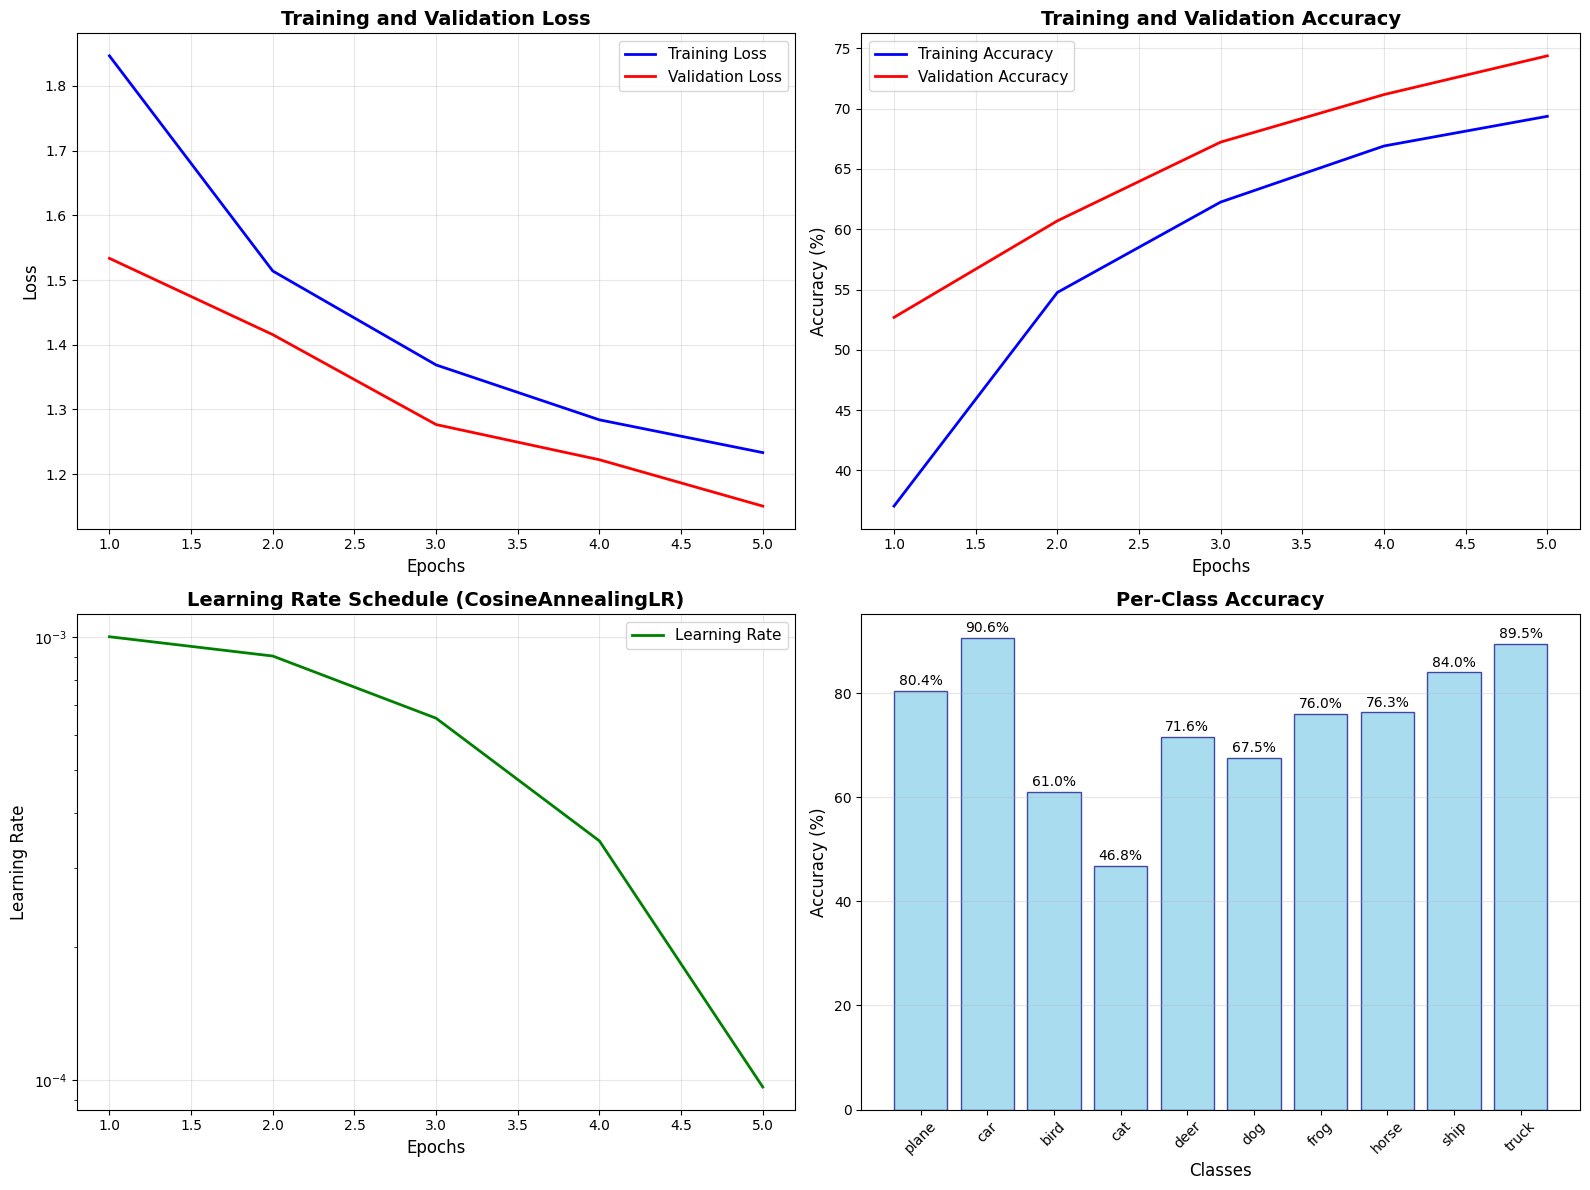


2. Model Predictions on Test Set:


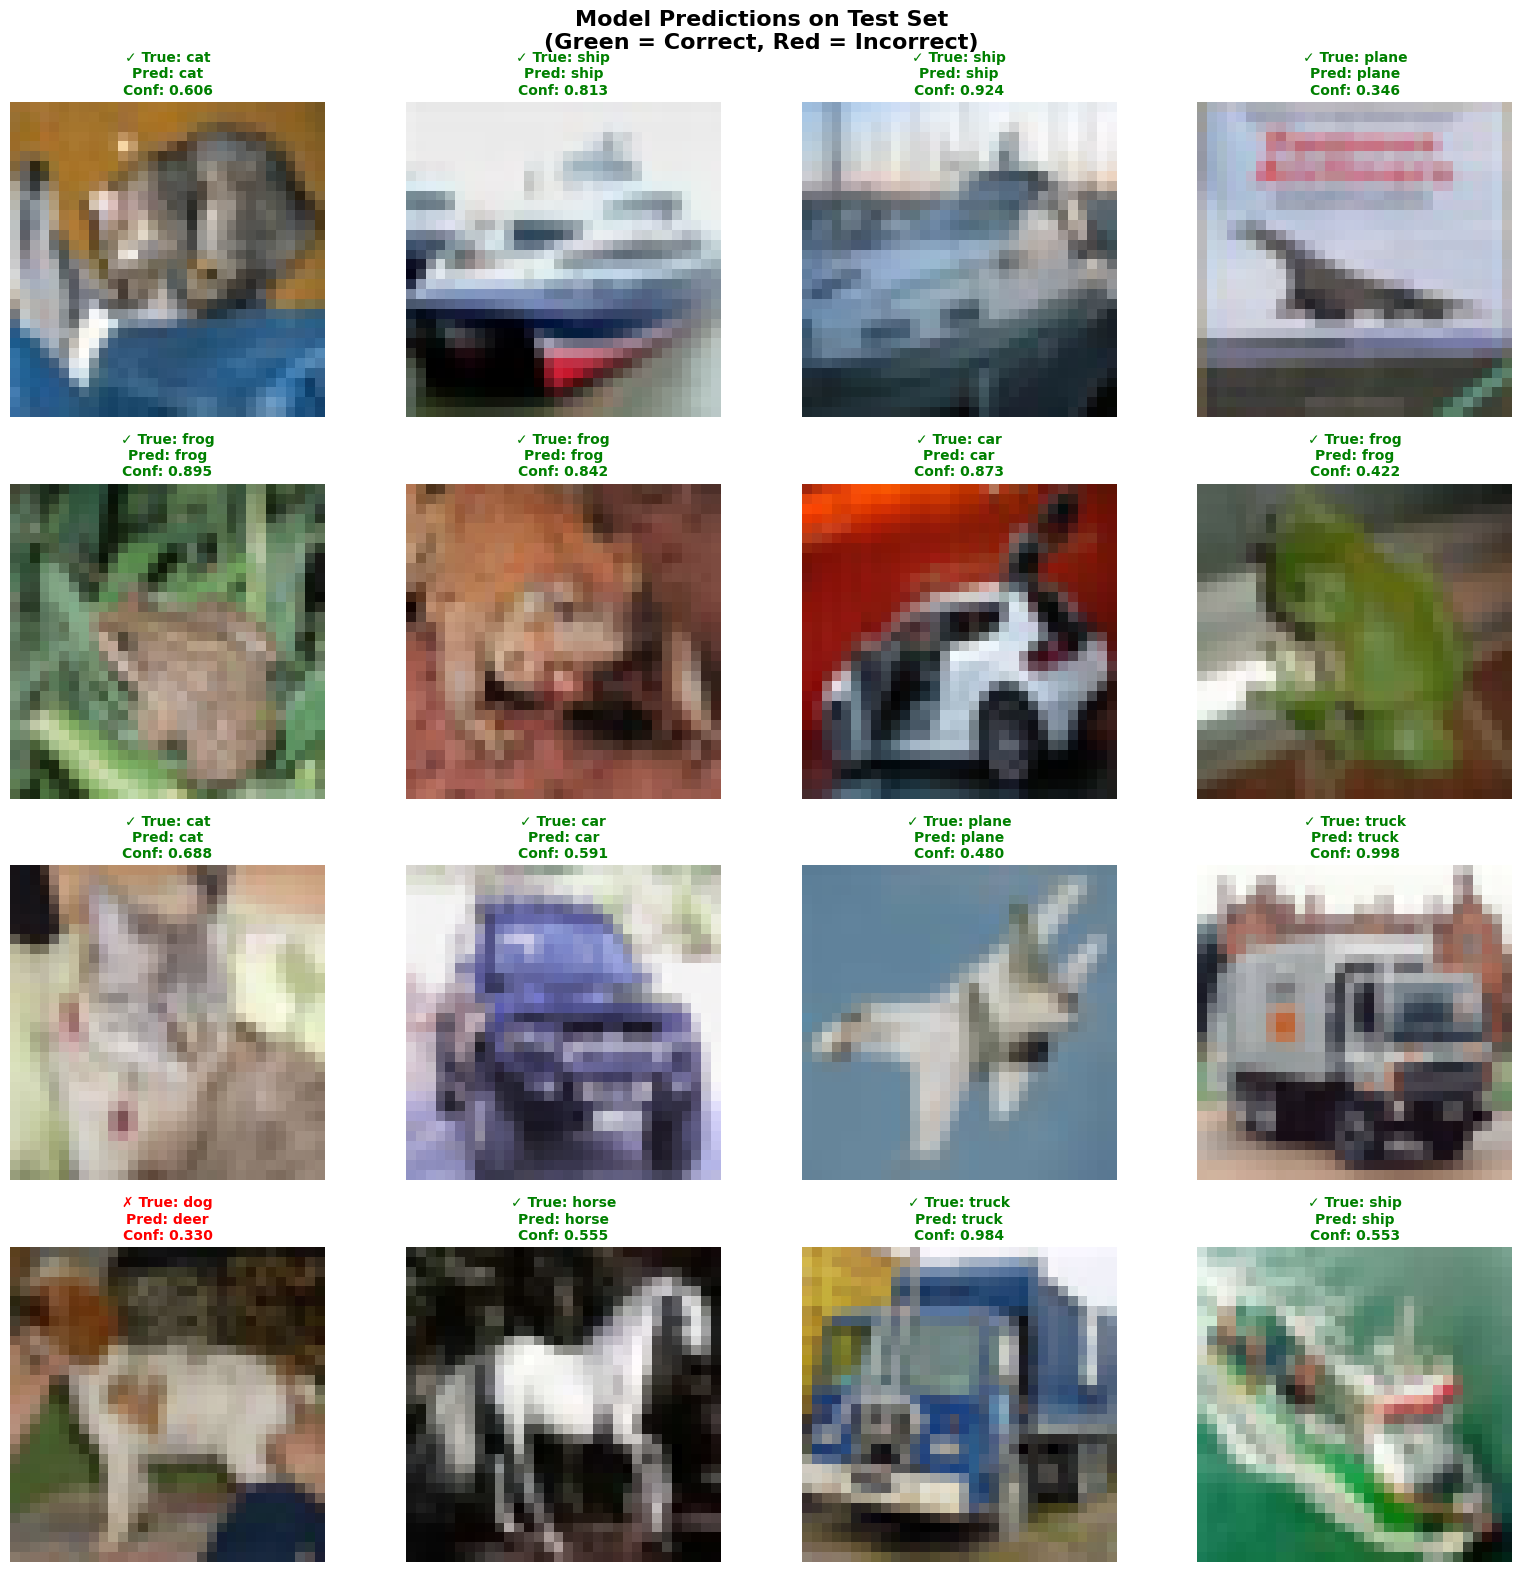


3. Performance Summary:


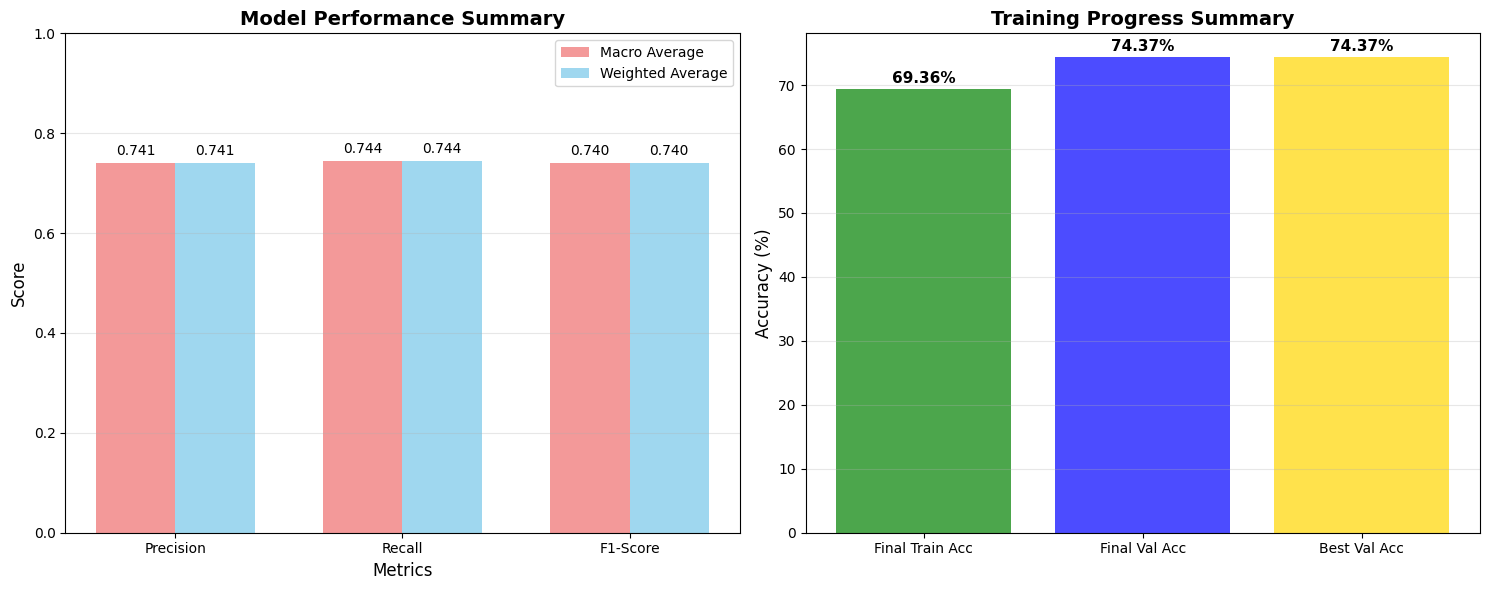


4. Model Architecture Summary:
Model: InceptionCNN with 4 Inception bottleneck blocks
Total Parameters: 3,300,618
Input Size: 32x32x3
Output Classes: 10
Training Time: 0.87 minutes
Final Validation Accuracy: 74.37%
Best Validation Accuracy: 74.37%

All visualizations completed!


In [53]:
# Create comprehensive plotting function
def plot_training_results():
    """Plot comprehensive training and validation results."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs_range = range(1, len(train_losses) + 1)
    
    # 1. Training and validation loss curves
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. Training and validation accuracy curves
    ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning rate schedule
    ax3.plot(epochs_range, learning_rates, 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title('Learning Rate Schedule (CosineAnnealingLR)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs', fontsize=12)
    ax3.set_ylabel('Learning Rate', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    # 4. Per-class accuracy bar chart
    class_acc_percent = [acc * 100 for acc in class_accuracies]
    bars = ax4.bar(classes, class_acc_percent, color='skyblue', edgecolor='navy', alpha=0.7)
    ax4.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Classes', fontsize=12)
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create prediction visualization function
def visualize_predictions(model, dataloader, device, classes, num_samples=16):
    """Show grid of test images with predicted vs true labels."""
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
    
    # Create visualization
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu()
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        confidence = probabilities[i][pred_label].item()
        
        # Denormalize image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img_np = img.numpy().transpose((1, 2, 0))
        
        # Display image
        axes[i].imshow(img_np)
        
        # Set title color based on correctness
        if true_label == pred_label:
            title_color = 'green'
            status = '✓'
        else:
            title_color = 'red'
            status = '✗'
        
        axes[i].set_title(f'{status} True: {classes[true_label]}\n'
                         f'Pred: {classes[pred_label]}\n'
                         f'Conf: {confidence:.3f}',
                         color=title_color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Model Predictions on Test Set\n(Green = Correct, Red = Incorrect)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create performance comparison chart
def plot_performance_summary():
    """Create a summary of model performance."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Metrics comparison
    metrics = ['Precision', 'Recall', 'F1-Score']
    macro_scores = [precision_macro, recall_macro, f1_macro]
    weighted_scores = [precision_weighted, recall_weighted, f1_weighted]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, macro_scores, width, label='Macro Average', 
                    color='lightcoral', alpha=0.8)
    bars2 = ax1.bar(x + width/2, weighted_scores, width, label='Weighted Average', 
                    color='skyblue', alpha=0.8)
    
    ax1.set_xlabel('Metrics', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Model Performance Summary', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Training progress summary
    final_train_acc = train_accuracies[-1]
    final_val_acc = val_accuracies[-1]
    best_val_acc = max(val_accuracies)
    
    progress_metrics = ['Final Train Acc', 'Final Val Acc', 'Best Val Acc']
    progress_values = [final_train_acc, final_val_acc, best_val_acc]
    colors = ['green', 'blue', 'gold']
    
    bars3 = ax2.bar(progress_metrics, progress_values, color=colors, alpha=0.7)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training Progress Summary', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Display all visualizations
print("Generating comprehensive visualizations...")
print("\n1. Training Results Overview:")
plot_training_results()

print("\n2. Model Predictions on Test Set:")
visualize_predictions(model, testloader, device, classes, num_samples=16)

print("\n3. Performance Summary:")
plot_performance_summary()

# Optional: Create architecture summary visualization
print(f"\n4. Model Architecture Summary:")
print("="*60)
print(f"Model: InceptionCNN with 4 Inception bottleneck blocks")
print(f"Total Parameters: {count_parameters(model):,}")
print(f"Input Size: {INPUT_SIZE}x{INPUT_SIZE}x3")
print(f"Output Classes: {NUM_CLASSES}")
print(f"Training Time: {total_time/60:.2f} minutes")
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
print("="*60)

print("\nAll visualizations completed!")

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (40%)**
   - Proper CNN architecture with Inception bottlenecks
   - Correct data augmentation and preprocessing
   - Working training loop with all optimizations

2. **Training and Results (25%)**
   - Model trains successfully without errors
   - Achieves reasonable accuracy on CIFAR-10 (>80%)
   - Proper use of regularization and scheduling

3. **Code Quality (20%)**
   - Clean, readable code with comprehensive comments
   - Proper tensor handling and memory management
   - Efficient implementation

4. **Analysis and Visualization (15%)**
   - Comprehensive evaluation with multiple metrics
   - Clear visualizations of results and training progress

**Bonus Points**:
- Creative architectural improvements
- Additional regularization techniques
- Hyperparameter optimization
- Ensemble methods or model averaging